In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 22})

analysis = 'Progression'

def format_fun(analysis,name):
    load = "../Reference Files/FOR RF - {analysis} - {name}.csv".format(analysis=analysis, name=name)
    fdata0 = pd.read_csv(load)
    fdata = fdata0[fdata0['Progression'] != 'Med']

    # Record which samples were used in train vs test
    if name == 'Taxonomy':
        X_ = fdata.drop(analysis, axis=1)
        y = fdata[analysis]
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.4, random_state=42)
        temp = pd.DataFrame({
        'Sample': X_train.Sample
        })
        tempname = "../Results/Supplementary Data/Random Forest/Samples used in training dataset - Progression.xlsx"
        writer=pd.ExcelWriter(tempname)
        temp.to_excel(writer,sheet_name="sheet")
        writer.close()

    # Record which samples were used in train vs test
    if name == 'Metabolites - Annotated Only':
        X_ = fdata.drop(analysis, axis=1)
        y = fdata[analysis]
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.4, random_state=42)
        temp = pd.DataFrame({
        'Sample': X_train.Sample
        })
        tempname = "../Results/Supplementary Data/Random Forest/Samples used in training dataset - Progression - Metabolites.xlsx"
        writer=pd.ExcelWriter(tempname)
        temp.to_excel(writer,sheet_name="sheet")
        writer.close()

    fdata = fdata.drop('Sample',axis=1)
    fdata = fdata.drop('Status',axis=1)
    fdata = fdata.drop('Estimate',axis=1)

    le = LabelEncoder()
    fdata['Sex'] = le.fit_transform(fdata['Sex'])
    fdata['Progression'] = le.fit_transform(fdata['Progression'])

    fdata_var = fdata[["Progression",'Sex','bristol','coffee_per_day']] # Covariables only
    fdata_bac = fdata.drop('bristol',axis=1) # Bacteria
    fdata_bac = fdata_bac.drop('Sex',axis=1)
    fdata_bac = fdata_bac.drop('coffee_per_day',axis=1)

    ffiles = []
    ffiles.append(fdata_var)
    ffiles.append(fdata_bac)
    ffiles.append(fdata)

    ffilenames = ["Covar",name,"{name} & Covar".format(name=name)]
    results = [ffiles,ffilenames]
    return results

In [2]:
# Load Datasets

bac = format_fun(analysis, 'Taxonomy')
meta = format_fun(analysis, 'MetaCyc')
ko = format_fun(analysis, 'KO')
cog = format_fun(analysis, 'COG')
ec = format_fun(analysis, 'EC')
met = format_fun(analysis, 'Metabolites - Annotated Only')

# Functions

In [3]:
def plot_output (ftrain,ttrain,ftest,ttest,ratrain,ratest,ytest,ypred,dataset_name,folder):
    plt.plot(ftrain, ttrain, color='black', linestyle='dotted',lw=2, label='Train: %0.2f' % ratrain)
    plt.plot(ftest, ttest, color='black', lw=2, label='Test: %0.2f' % ratest)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name}')
    plt.legend(loc='lower right')
    # Saving figure by changing parameter values
    if (dataset_name == 'Taxonomy' or dataset_name == 'MetaCyc' or dataset_name == 'Covar' or dataset_name == 'Taxonomy & Covar' or dataset_name == 'MetaCyc & Covar'):
        savename = "../Results/5. Random Forest/ROC Curve - {analysis} - {df}.png".format(analysis=analysis, df=dataset_name)
    else:
        savename = "../Results/Supplementary Figures/ROC Curve - {analysis} - {df}.png".format(analysis=analysis, df=dataset_name)
        
    plt.savefig(savename, format="png", bbox_inches="tight")
    plt.show()
    plt.close()

    conf_matrix = confusion_matrix(ytest, ypred)

    return conf_matrix

In [4]:
def run_rf(df,dataset_name,folder):
        print(f"Dataset: {dataset_name}")

        # Create test/train x,y
        X_ = df.drop(analysis, axis=1)
        y = df[analysis]
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=testsize, random_state=421)

        # Set up empty RF model
        rf_model = RandomForestClassifier(class_weight='balanced_subsample',random_state=421)

        # Hyperparameter tuning using Grid Search
        param_grid = {
                'n_estimators': [50, 75, 100],
                'max_depth': [3,4,5,7,10],
                'min_samples_split': [21,22,23]
        }
        grid_search = GridSearchCV(
                rf_model, param_grid, cv=5, scoring=auc_scorer, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Best model found:
        best_params = grid_search.best_params_
        print(best_params)

        # RUN RF USING BEST PARAMS
        rfc=RandomForestClassifier(random_state=421, **grid_search.best_params_)
        rfc.fit(X_train, y_train)
        pred=rfc.predict(X_test)
        print("Accuracy for Random Forest on test dataset: ",accuracy_score(y_test,pred))

        # Plot ROC Curve and Confusion Matrix
        y_train_pred_prob = rfc.predict_proba(X_train)[:, 1]
        y_test_pred_prob = rfc.predict_proba(X_test)[:, 1]

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

        roc_auc_train = auc(fpr_train, tpr_train)
        roc_auc_test = auc(fpr_test, tpr_test)

        plots = plot_output(fpr_train,tpr_train,fpr_test,tpr_test,roc_auc_train,roc_auc_test,y_test,pred,dataset_name,folder)

        # Feature Importance
        feature_importances = rfc.feature_importances_

        importance_df = pd.DataFrame({
        'Feature': X_.columns,
        'Importance': feature_importances
        })

        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print(importance_df)

        results = [best_params,accuracy_score(y_test,pred),plots,importance_df]
        return results

# Covars Only

Dataset: Covar
{'max_depth': 3, 'min_samples_split': 22, 'n_estimators': 50}
Accuracy for Random Forest on test dataset:  0.5


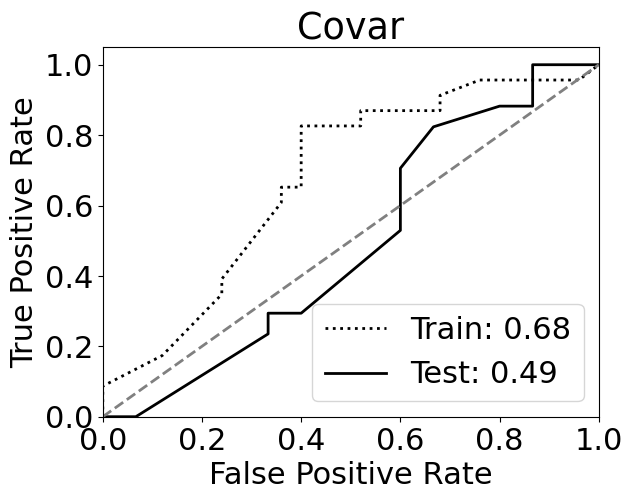

          Feature  Importance
2  coffee_per_day    0.425349
0             Sex    0.328904
1         bristol    0.245747


In [5]:
# Set Parameters
testsize = 0.4
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = bac # Use first dataset to run covariable analysis (since covars are same for all datasets)
folder = 'Covar'

params_cov = []
accuracy_cov = []
conf_cov = []
importance_cov = []

dataset = dataset_of_interest[0][0]
name = dataset_of_interest[1][0]
rf = run_rf(dataset,name,folder)
params_cov.append(rf[0])
accuracy_cov.append(rf[1])
conf_cov.append(rf[2])
importance_cov.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - Covars.xlsx".format(analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance_cov):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i]))
writer.close()

# Taxonomy

Dataset: Taxonomy
{'max_depth': 3, 'min_samples_split': 21, 'n_estimators': 100}
Accuracy for Random Forest on test dataset:  0.625


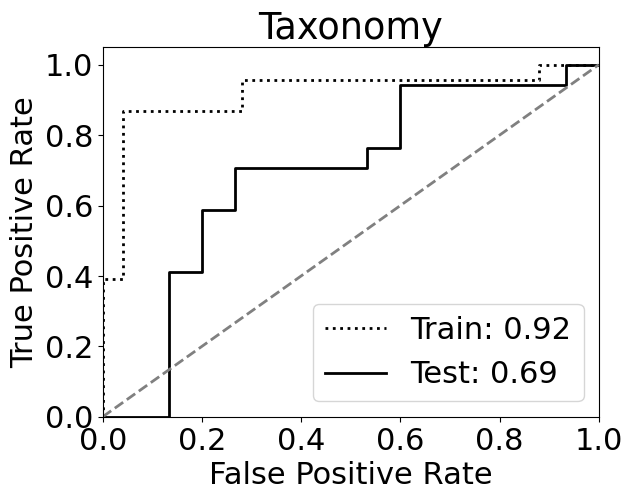

                              Feature  Importance
0     s__Faecalibacterium_prausnitzii    0.232504
6                    s__Blautia_obeum    0.130055
1           s__Roseburia_intestinalis    0.117723
2  s__Ruthenibacterium_lactatiformans    0.115033
3          s__Roseburia_inulinivorans    0.111806
7                s__Coprococcus_catus    0.108929
5           s__Alistipes_indistinctus    0.095191
4                 s__Blautia_wexlerae    0.088758
Dataset: Taxonomy & Covar
{'max_depth': 3, 'min_samples_split': 23, 'n_estimators': 100}
Accuracy for Random Forest on test dataset:  0.65625


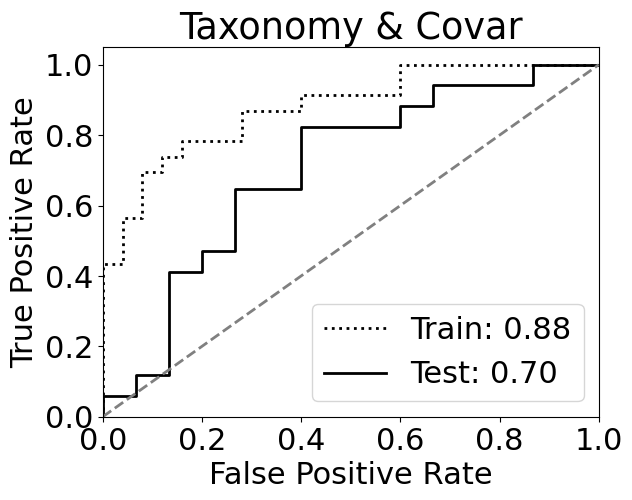

                               Feature  Importance
3      s__Faecalibacterium_prausnitzii    0.196081
2                       coffee_per_day    0.165049
4            s__Roseburia_intestinalis    0.127978
6           s__Roseburia_inulinivorans    0.126454
7                  s__Blautia_wexlerae    0.119125
9                     s__Blautia_obeum    0.067160
10                s__Coprococcus_catus    0.049617
1                              bristol    0.047629
8            s__Alistipes_indistinctus    0.040946
5   s__Ruthenibacterium_lactatiformans    0.039960
0                                  Sex    0.020000


In [6]:
# Set Parameters
testsize = 0.4
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = bac
folder = 'Taxonomy'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_b = params
accuracy_b = accuracy
conf_b = conf
importance_b = importance

# MetaCyc

Dataset: MetaCyc
{'max_depth': 3, 'min_samples_split': 23, 'n_estimators': 75}
Accuracy for Random Forest on test dataset:  0.71875


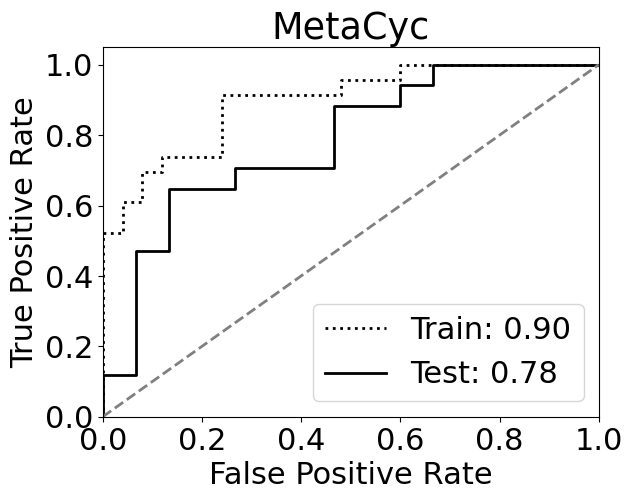

                                             Feature  Importance
0  PWY66-409: superpathway of purine nucleotide s...    0.203189
3  PWY-6471: peptidoglycan biosynthesis IV (Enter...    0.173480
1  PWY-7383: anaerobic energy metabolism (inverte...    0.149879
5  GALACT-GLUCUROCAT-PWY: superpathway of hexuron...    0.134814
4  GLUCUROCAT-PWY: superpathway of &beta;-D-glucu...    0.133762
6               PWY-7242: D-fructuronate degradation    0.103152
2                 PWY-5177: glutaryl-CoA degradation    0.101725
Dataset: MetaCyc & Covar
{'max_depth': 3, 'min_samples_split': 23, 'n_estimators': 100}
Accuracy for Random Forest on test dataset:  0.71875


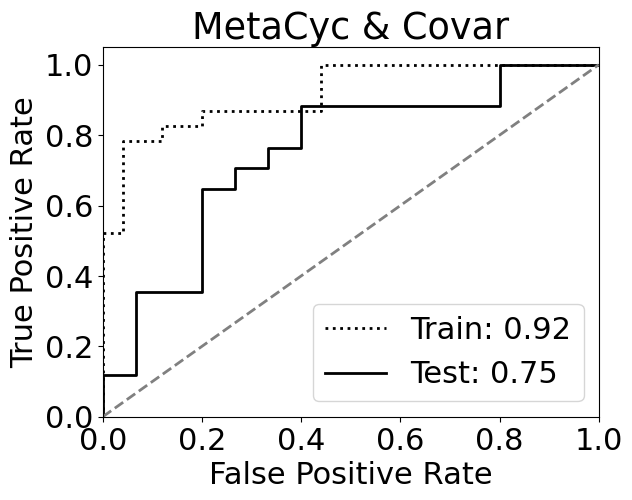

                                             Feature  Importance
3  PWY66-409: superpathway of purine nucleotide s...    0.284080
6  PWY-6471: peptidoglycan biosynthesis IV (Enter...    0.141623
4  PWY-7383: anaerobic energy metabolism (inverte...    0.132669
9               PWY-7242: D-fructuronate degradation    0.096693
7  GLUCUROCAT-PWY: superpathway of &beta;-D-glucu...    0.092719
2                                     coffee_per_day    0.086084
8  GALACT-GLUCUROCAT-PWY: superpathway of hexuron...    0.067735
5                 PWY-5177: glutaryl-CoA degradation    0.066068
1                                            bristol    0.028650
0                                                Sex    0.003678


In [7]:
# Set Parameters
testsize = 0.4
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = meta
folder = 'MetaCyc'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_m = params
accuracy_m = accuracy
conf_m = conf
importance_m = importance

# KO

Dataset: KO
{'max_depth': 3, 'min_samples_split': 22, 'n_estimators': 100}
Accuracy for Random Forest on test dataset:  0.625


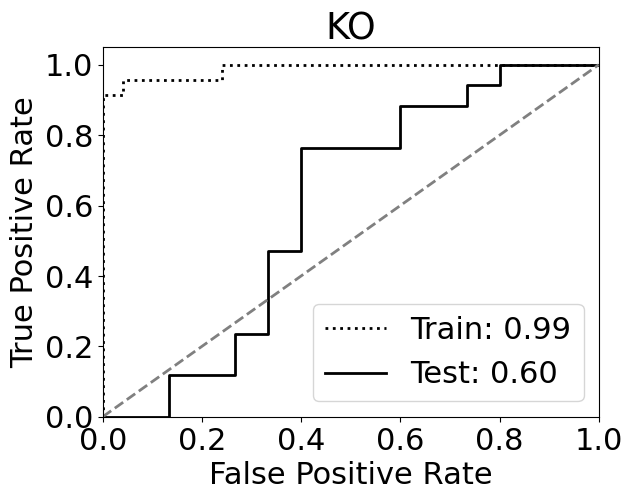

                                              Feature  Importance
30  K02746: N-acetylgalactosamine PTS system EIIC ...    0.075156
46  K03292: glycoside/pentoside/hexuronide:cation ...    0.073245
39  K03823: phosphinothricin acetyltransferase [EC...    0.062052
57  K07793: putative tricarboxylic transport membr...    0.051089
37  K00563: 23S rRNA (guanine745-N1)-methyltransfe...    0.036475
41        K01875: seryl-tRNA synthetase [EC:6.1.1.11]    0.034468
53                       K07301: cation:H+ antiporter    0.030784
7        K21929: uracil-DNA glycosylase [EC:3.2.2.27]    0.030307
2   K22293: GntR family transcriptional regulator,...    0.027674
8         K01273: membrane dipeptidase [EC:3.4.13.19]    0.027598
12        K02440: glycerol uptake facilitator protein    0.025721
23              K02022: HlyD family secretion protein    0.025539
51  K17318: putative aldouronate transport system ...    0.024440
22  K09819: manganese/iron transport system permea...    0.023410
31        

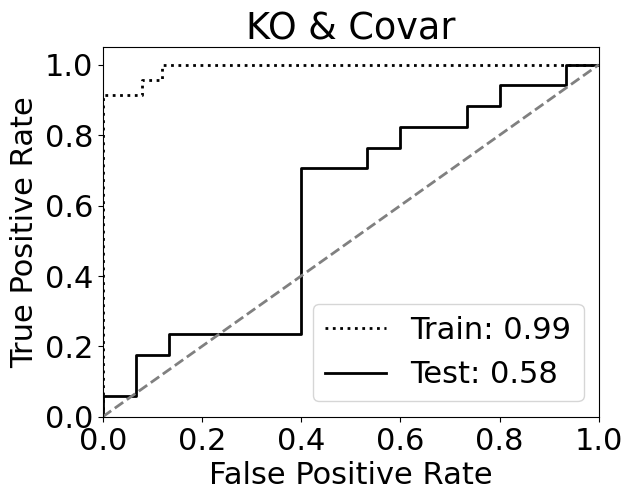

                                              Feature  Importance
49  K03292: glycoside/pentoside/hexuronide:cation ...    0.089231
33  K02746: N-acetylgalactosamine PTS system EIIC ...    0.080402
61             K02837: peptide chain release factor 3    0.079153
58                   K08659: dipeptidase [EC:3.4.-.-]    0.071543
5   K22293: GntR family transcriptional regulator,...    0.042552
..                                                ...         ...
35        K02871: large subunit ribosomal protein L13    0.000000
24  K01693: imidazoleglycerol-phosphate dehydratas...    0.000000
25  K09819: manganese/iron transport system permea...    0.000000
1                                             bristol    0.000000
0                                                 Sex    0.000000

[62 rows x 2 columns]


In [8]:
# Set Parameters
testsize = 0.4
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = ko
folder = 'KO'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_k = params
accuracy_k = accuracy
conf_k = conf
importance_k = importance

# COG

Dataset: COG
{'max_depth': 3, 'min_samples_split': 21, 'n_estimators': 50}
Accuracy for Random Forest on test dataset:  0.6875


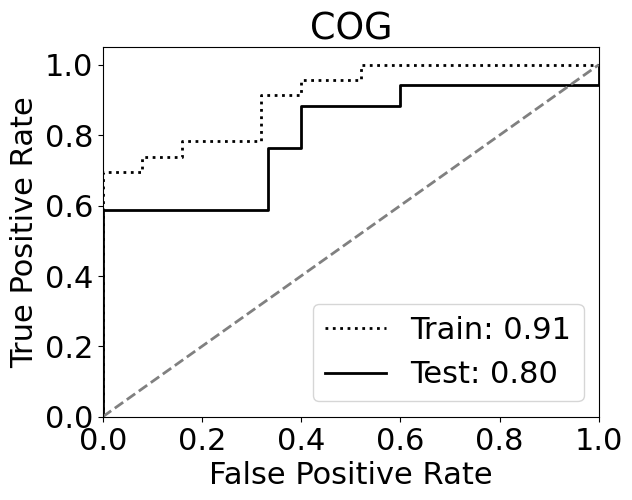

                                              Feature  Importance
17  COG0232: deoxyguanosinetriphosphate triphospho...    0.094440
5                    COG0406: Phosphoglycerate mutase    0.071860
32                          COG1686: Carboxypeptidase    0.070404
10          COG2206: Metal Dependent Phosphohydrolase    0.069046
33  COG1227: Manganese-dependent inorganic pyropho...    0.054293
3                        COG1247: N-acetyltransferase    0.052093
25                                 COG0530: exchanger    0.051285
34  COG1015: Phosphotransfer between the C1[...]om...    0.047361
8                            COG1335: isochorismatase    0.043936
37                        COG0069: glutamate synthase    0.036359
30                                  COG0800: Aldolase    0.033754
0                                COG0671: PHOsphatase    0.029514
13   COG4948: mandelate racemase muconate lactonizing    0.028694
23  COG0718: Binds to DNA and alters its co[...]DN...    0.028488
1   COG146

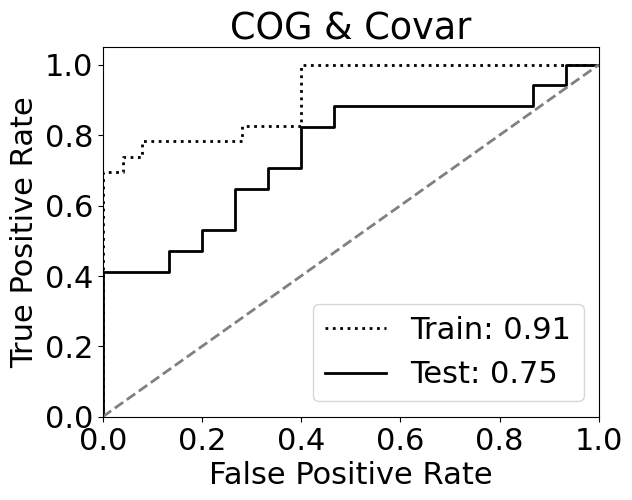

                                              Feature  Importance
28                                 COG0530: exchanger    0.078535
11                           COG1335: isochorismatase    0.061215
8                    COG0406: Phosphoglycerate mutase    0.061212
35                          COG1686: Carboxypeptidase    0.060348
2                                      coffee_per_day    0.048370
30                 COG5523: integral membrane protein    0.044714
13          COG2206: Metal Dependent Phosphohydrolase    0.044695
20  COG0232: deoxyguanosinetriphosphate triphospho...    0.042803
40                        COG0069: glutamate synthase    0.041831
38  COG2239: magnesium ion transmembrane transport...    0.030901
26  COG0718: Binds to DNA and alters its co[...]DN...    0.030694
12  COG0154: Allows the formation of correc[...]-G...    0.030685
33                                  COG0800: Aldolase    0.029510
4   COG1469: Converts GTP to 7,8-dihydroneo[...]n ...    0.029330
3         

In [9]:
# Set Parameters
testsize = 0.4
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = cog
folder = 'COG'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_c = params
accuracy_c = accuracy
conf_c = conf
importance_c = importance

# EC

Dataset: EC
{'max_depth': 3, 'min_samples_split': 23, 'n_estimators': 100}
Accuracy for Random Forest on test dataset:  0.625


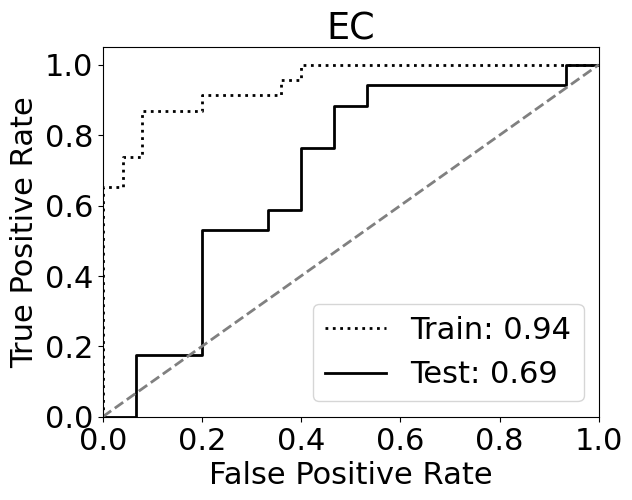

                                              Feature  Importance
19                ADENOSYLHOMOCYSTEINASE-RXN: NO_NAME    0.123757
37                              4.3.1.17-RXN: NO_NAME    0.089654
4                               4.1.1.32-RXN: NO_NAME    0.077222
7                     4OH2OXOGLUTARALDOL-RXN: NO_NAME    0.070531
20                                 RXN-11586: NO_NAME    0.042456
13                        THYMIDYLATESYN-RXN: NO_NAME    0.037229
43             GLUCONATE-5-DEHYDROGENASE-RXN: NO_NAME    0.034544
1                                  RXN0-6482: NO_NAME    0.033001
5                                  RXN-12481: NO_NAME    0.032607
12                                RXN8J2-140: NO_NAME    0.030729
22                   OHACYL-COA-DEHYDROG-RXN: NO_NAME    0.030000
0                                  RXN0-6481: NO_NAME    0.029103
3                                 DTMPKI-RXN: NO_NAME    0.028360
10              PYROGLUTAMYL-PEPTIDASE-I-RXN: NO_NAME    0.027540
41        

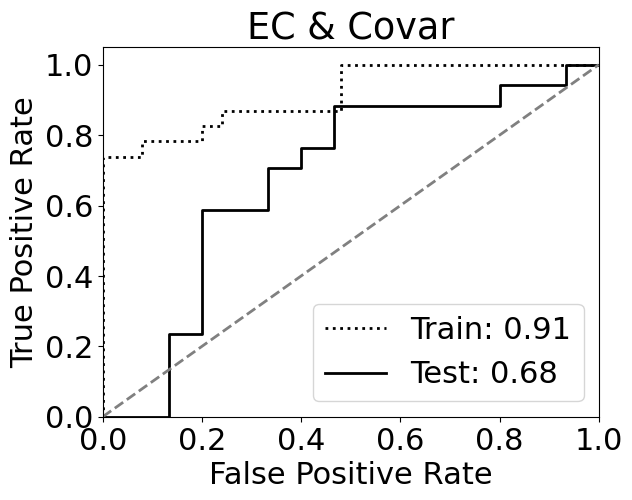

                                              Feature  Importance
22                ADENOSYLHOMOCYSTEINASE-RXN: NO_NAME    0.083217
44                                  RXN-2102: NO_NAME    0.079484
39                             KDPGALDOL-RXN: NO_NAME    0.070518
8                                  RXN-12481: NO_NAME    0.060000
40                              4.3.1.17-RXN: NO_NAME    0.054221
23                                 RXN-11586: NO_NAME    0.049645
25                   OHACYL-COA-DEHYDROG-RXN: NO_NAME    0.040000
27                                 RXN-10702: NO_NAME    0.035212
17                    TRNA-S-TRANSFERASE-RXN: NO_NAME    0.032868
13              PYROGLUTAMYL-PEPTIDASE-I-RXN: NO_NAME    0.032711
14                     MANNONOXIDOREDUCT-RXN: NO_NAME    0.032582
16                        THYMIDYLATESYN-RXN: NO_NAME    0.031689
34  RXN-12750: 3-[(3aS,4S,5R,7aS)-5-hydroxy-7a-met...    0.031653
2                                      coffee_per_day    0.031201
21        

In [10]:
# Set Parameters
testsize = 0.4
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = ec
folder = 'EC'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_e = params
accuracy_e = accuracy
conf_e = conf
importance_e = importance